In [1]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
from OutilsP4 import *
import seaborn as sns

In [2]:
data = pd.read_csv("2016_Building_Energy_Benchmarking.csv")

Il y a 19952 valeurs manquantes sur 155296 valeurs totales.
Le taux de remplissage est de : 87.15 %
Dimension du dataframe : (3376, 46)


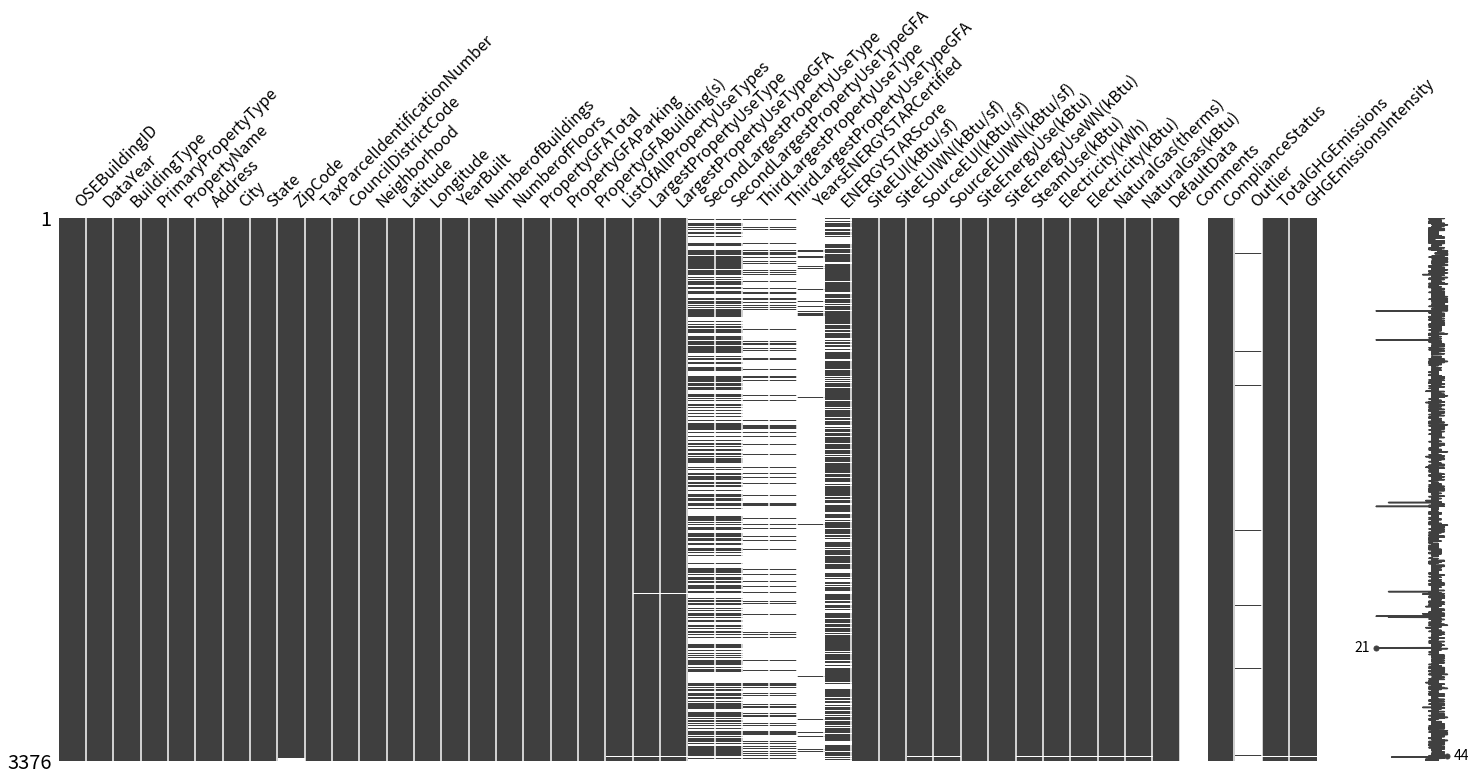

In [3]:
missingValuesInfos(data)

In [4]:
data.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'DefaultData', 'Comments', 'ComplianceStatus',
       'Outlier

# <font color='red'>I - Nettoyage</font>

- Supression des colonnes avec une valeur unique.

In [5]:
for e in data.columns :
    if len(data[e].unique()) == 1 :
        print(e)
        data.pop(e)
data.shape

DataYear
City
State
Comments


(3376, 42)

- Supression des individus avec des valeurs manquantes, sauf dans les colonnes suivantes

In [6]:
listCol = data.columns.to_list()
listCol.remove('SecondLargestPropertyUseType')
listCol.remove('SecondLargestPropertyUseTypeGFA')
listCol.remove('ThirdLargestPropertyUseType')
listCol.remove('ThirdLargestPropertyUseTypeGFA')
listCol.remove('YearsENERGYSTARCertified')
listCol.remove('ENERGYSTARScore')
listCol.remove('Outlier')

In [7]:
data.dropna(axis = 0, how = 'any', inplace = True, subset = listCol)
data.shape

(3337, 42)

- Suppresison des individus qui représente des bâtiments résidentiels

In [8]:
data = data[~data["BuildingType"].str.contains("Multifamily")]
data.shape

(1644, 42)

In [9]:
data.loc[data["LargestPropertyUseType"] == 'Multifamily Housing',"LargestPropertyUseType"] = np.nan
data.dropna(axis = 0, how = 'any', inplace = True, subset = "LargestPropertyUseType")
data.shape

(1632, 42)

- Supression des individus classé comme "Outliers"

In [10]:
data = data.loc[data["Outlier"].isna(),:].copy()
data.pop("Outlier")
data.shape

(1616, 41)

- Supression des individus dont les valeurs sont noté non-conformes

In [11]:
data = data[data["ComplianceStatus"]=="Compliant"]
data.pop("ComplianceStatus")
data.shape

(1519, 40)

In [12]:
data.pop("DefaultData")
data.shape

(1519, 39)

In [13]:
mask = 1.1*(data["SteamUse(kBtu)"] + data["Electricity(kBtu)"] + data["NaturalGas(kBtu)"]) < data["SiteEnergyUse(kBtu)"]
data = data[~mask]
data.shape

(1505, 39)

In [14]:
data = data[~mask]

/tmp/ipykernel_177/2717268839.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = data[~mask]


Il y a 5653 valeurs manquantes sur 58695 valeurs totales.
Le taux de remplissage est de : 90.36 %
Dimension du dataframe : (1505, 39)


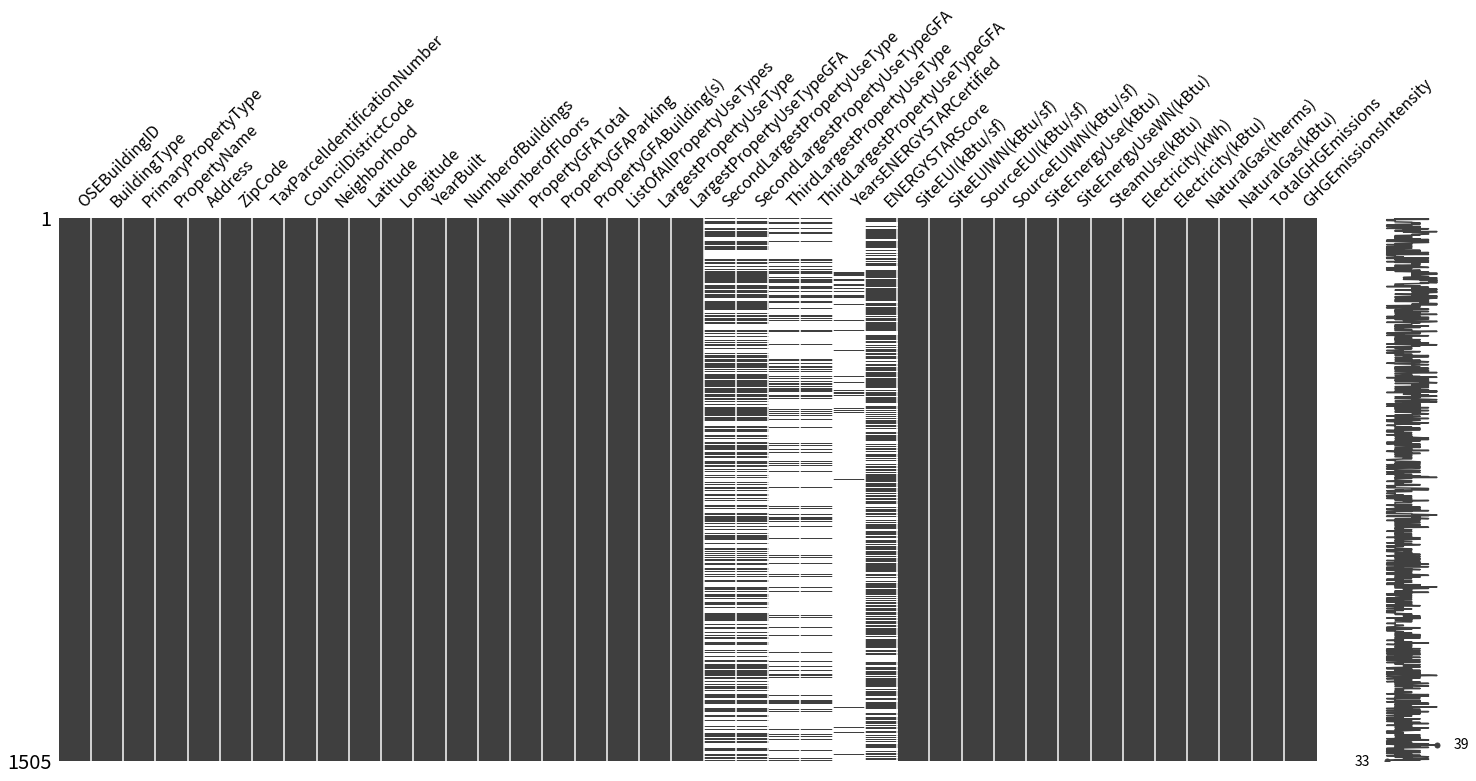

In [15]:
missingValuesInfos(data)

# <font color='red'>II - Correction et création de variables </font>

- Mise en forme de "Neighborhood"

In [16]:
data["Neighborhood"] = data["Neighborhood"].str.capitalize()

- Dans BuildingType, Non Residential WA devient Non Residential (car il y en a que un seul)

In [17]:
data.loc[data["BuildingType"] == "Nonresidential WA", "BuildingType"] = "NonResidential"

- Une variable suplémentaire : NumberOfUseTypes

In [18]:
values = data.loc[:,['LargestPropertyUseType','SecondLargestPropertyUseType','ThirdLargestPropertyUseType']].notna().sum(axis = 1)
data.insert(loc = 24, column = "NumberOfUseTypes", value = values)

- On ajoute une variable DistanceFromCenter, depuis Latitude et Longitude, en negligeant la courbure de la terre aux alentours de Seattle

In [19]:
Latitude = data["Latitude"] - 47.608013
Longitude = data["Longitude"] + 122.335167
values = Latitude**2 + Longitude**2
values = values**(1/2)

data.insert(loc = 11, column = "DistanceFromCenter", value = values)

- On ajoute 2 variables BuildingAge et BuildingPeriod, depuis la variable YearBuilt

In [20]:
#BuildingAge
values = 2016 - data["YearBuilt"]
data.insert(loc = 13, column = "BuildingAge", value = values)

In [21]:
#BuildingPeriod (une catégorie par décenie)
values = data["YearBuilt"] - data["YearBuilt"]%10
values = values.astype(str)
data.insert(loc = 14, column = "BuildingPeriod", value = values)

- Les petites valeurs de la variable "LargestPropertyUseType" seront ramenées à une catégorie similaire ou "Other"

In [22]:
data["LargestPropertyUseType"].value_counts()

Office                                                  479
Non-Refrigerated Warehouse                              197
Retail Store                                             92
Other                                                    91
Hotel                                                    75
Worship Facility                                         69
Distribution Center                                      54
K-12 School                                              50
Medical Office                                           41
Supermarket/Grocery Store                                40
Parking                                                  30
Self-Storage Facility                                    27
Residence Hall/Dormitory                                 22
Other - Entertainment/Public Assembly                    21
College/University                                       21
Other - Recreation                                       21
Senior Care Community                   

In [23]:
# Tri par catégories similaires
data.loc[data["LargestPropertyUseType"] == "Other - Restaurant/Bar","LargestPropertyUseType"] = "Restaurant"
data.loc[data["LargestPropertyUseType"] == "Food Service","LargestPropertyUseType"] = "Restaurant"
data.loc[data["LargestPropertyUseType"] == "Other/Specialty Hospital","LargestPropertyUseType"] = "Hospital (General Medical & Surgical)"
data.loc[data["LargestPropertyUseType"] == "Urgent Care/Clinic/Other Outpatient","LargestPropertyUseType"] = "Hospital (General Medical & Surgical)"
data.loc[data["LargestPropertyUseType"] == "Other - Education","LargestPropertyUseType"] = "K-12 School"
data.loc[data["LargestPropertyUseType"] == "Pre-school/Daycare","LargestPropertyUseType"] = "K-12 School"
data.loc[data["LargestPropertyUseType"] == "Other - Mall","LargestPropertyUseType"] = "Mall"
data.loc[data["LargestPropertyUseType"] == "Strip Mall","LargestPropertyUseType"] = "Mall"
data.loc[data["LargestPropertyUseType"] == "Library","LargestPropertyUseType"] = "Retail Store"
data.loc[data["LargestPropertyUseType"] == "Financial Office","LargestPropertyUseType"] = "Office"
data.loc[data["LargestPropertyUseType"] == "Bank Branch","LargestPropertyUseType"] = "Office"
data.loc[data["LargestPropertyUseType"] == "Adult Education","LargestPropertyUseType"] = "College/University"
data.loc[data["LargestPropertyUseType"] == "Museum","LargestPropertyUseType"] = "Other - Entertainment/Public Assembly"
data.loc[data["LargestPropertyUseType"] == "Movie Theater","LargestPropertyUseType"] = "Other - Entertainment/Public Assembly"
data.loc[data["LargestPropertyUseType"] == "Hospital (General Medical & Surgical)","LargestPropertyUseType"] = "Medical Office"
data.loc[data["LargestPropertyUseType"] == "Laboratory","LargestPropertyUseType"] = "Medical Office"
data.loc[data["LargestPropertyUseType"] == "Senior Care Community","LargestPropertyUseType"] = "Medical Office"
data.loc[data["LargestPropertyUseType"] == "Restaurant","LargestPropertyUseType"] = "Hotel"
data.loc[data["LargestPropertyUseType"] == "Other - Recreation","LargestPropertyUseType"] = "Other - Entertainment/Public Assembly"

In [24]:
#Tri par "Other"
otherList = data["LargestPropertyUseType"].value_counts()[data["LargestPropertyUseType"].value_counts()<15].index.tolist()
data.loc[data["LargestPropertyUseType"].isin(otherList),"LargestPropertyUseType"] = "Other"
data["LargestPropertyUseType"].value_counts().sort_values(ascending = False)

Office                                   487
Non-Refrigerated Warehouse               197
Other                                    175
Retail Store                              96
Medical Office                            92
Hotel                                     90
Worship Facility                          69
K-12 School                               55
Distribution Center                       54
Other - Entertainment/Public Assembly     48
Supermarket/Grocery Store                 40
Parking                                   30
Self-Storage Facility                     27
College/University                        23
Residence Hall/Dormitory                  22
Name: LargestPropertyUseType, dtype: int64

- Surface parking ramenée a % de la surface totale

In [25]:
data["PropertyGFAParking"]

0            0
1        15064
2       196718
3            0
4        62000
         ...  
3339         0
3340         0
3347         0
3356     85028
3359         0
Name: PropertyGFAParking, Length: 1505, dtype: int64

In [26]:
values = data["PropertyGFAParking"]/data["PropertyGFATotal"] * 100
values.round(decimals = 2)
data.insert(loc = 19, column = "PropertyGFApctParking", value = values)

- Surface Building ramenée a % de la surface totale

In [27]:
values = data["PropertyGFABuilding(s)"]/data["PropertyGFATotal"] * 100
values.round(decimals = 2)
data.insert(loc = 21, column = "PropertyGFApctBuilding(s)", value = values)

- Surface LargestPropertyUseType ramenée a % de la surface totale

In [28]:
values = data["LargestPropertyUseTypeGFA"]/data["PropertyGFATotal"] * 100
values.round(decimals = 2)
data.insert(loc = 25, column = "LargestPropertyUseTypeGFApct", value = values)

- Production d'energie prédominante

In [29]:
values = [np.nan for i in range (data.shape[0])]
data.insert(loc = 44, column = "BiggestEnergyProduction", value = values)

mask1 = data["SteamUse(kBtu)"] >= data["Electricity(kBtu)"]
mask2 = data["SteamUse(kBtu)"] >= data["NaturalGas(kBtu)"]
data.loc[mask1*mask2,"BiggestEnergyProduction"] = "Steam"

mask1 = data["Electricity(kBtu)"] >= data["SteamUse(kBtu)"]
mask2 = data["Electricity(kBtu)"] >= data["NaturalGas(kBtu)"]
data.loc[mask1*mask2,"BiggestEnergyProduction"] = "Electricity"

mask1 = data["NaturalGas(kBtu)"] >= data["Electricity(kBtu)"]
mask2 = data["NaturalGas(kBtu)"] >= data["SteamUse(kBtu)"]
data.loc[mask1*mask2,"BiggestEnergyProduction"] = "NaturalGas"

- % de production d'energie

In [30]:
values = data["SteamUse(kBtu)"]/data["SiteEnergyUse(kBtu)"] * 100
data.insert(loc = 40, column = "SteamProdPct", value = values)

values = data["Electricity(kBtu)"]/data["SiteEnergyUse(kBtu)"] * 100
data.insert(loc = 43, column = "ElectricityProdPct", value = values)

values = data["NaturalGas(kBtu)"]/data["SiteEnergyUse(kBtu)"] * 100
data.insert(loc = 46, column = "NaturalGasProdPct", value = values)

- Surface totale ramenée au surface par étage

In [31]:
values = data["PropertyGFATotal"]
mask = data["NumberofFloors"] != 0
values.loc[mask,] = (data.loc[mask, "PropertyGFATotal"] / data.loc[mask, "NumberofFloors"]).copy()
data.insert(loc = 18, column = "PropertyGFAPerFloor", value = values)

/tmp/ipykernel_177/3538458639.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  values.loc[mask,] = (data.loc[mask, "PropertyGFATotal"] / data.loc[mask, "NumberofFloors"]).copy()


Il y a 5653 valeurs manquantes sur 76755 valeurs totales.
Le taux de remplissage est de : 92.63 %
Dimension du dataframe : (1505, 51)


Index(['OSEBuildingID', 'BuildingType', 'PrimaryPropertyType', 'PropertyName',
       'Address', 'ZipCode', 'TaxParcelIdentificationNumber',
       'CouncilDistrictCode', 'Neighborhood', 'Latitude', 'Longitude',
       'DistanceFromCenter', 'YearBuilt', 'BuildingAge', 'BuildingPeriod',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAPerFloor', 'PropertyGFAParking', 'PropertyGFApctParking',
       'PropertyGFABuilding(s)', 'PropertyGFApctBuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'LargestPropertyUseTypeGFApct',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'NumberOfUseTypes', 'YearsENERGYSTARCertified', 'ENERGYSTARScore',
       'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)',
       'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)',
       '

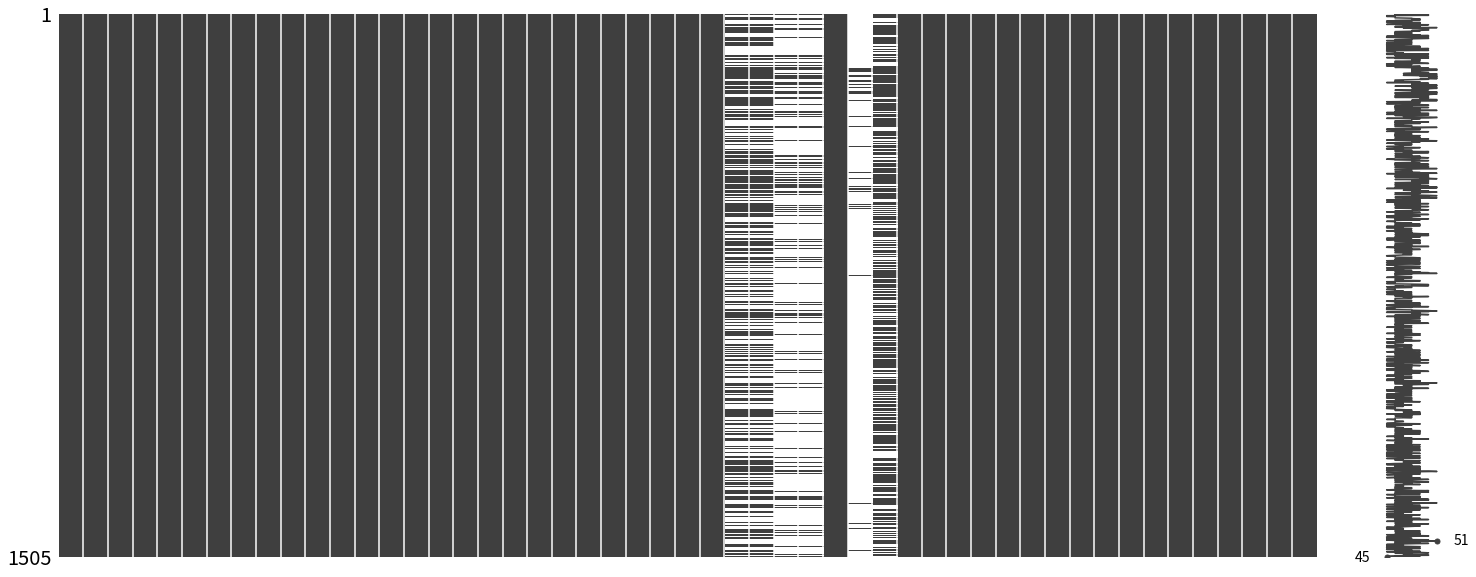

In [32]:
missingValuesInfos(data)
data.columns

In [33]:
data['ENERGYSTARScore'].isna().sum()

521

In [34]:
# libération mémoire
del values
del Latitude
del Longitude
del mask

# <font color='red'>III - Exploration </font>

## <font color='green'>III/1 - Analyse univariée </font>

<AxesSubplot:ylabel='BuildingType'>

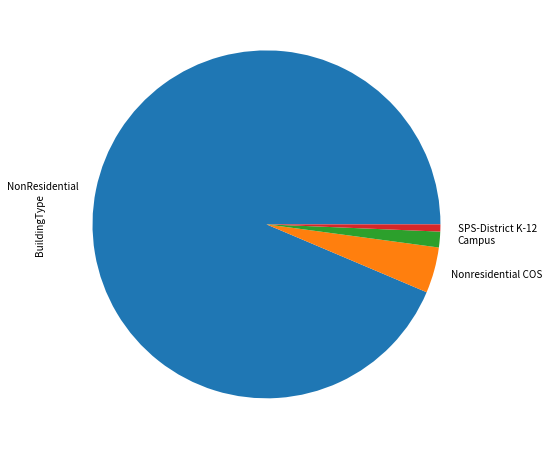

In [35]:
data["BuildingType"].value_counts().plot.pie(figsize = (8,8))

<AxesSubplot:ylabel='Neighborhood'>

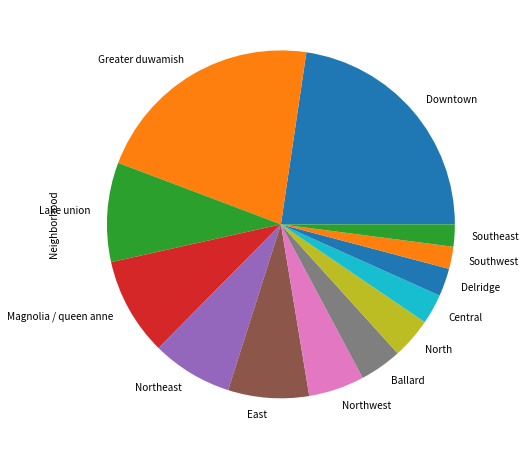

In [36]:
data["Neighborhood"].value_counts().plot.pie(figsize = (8,8))

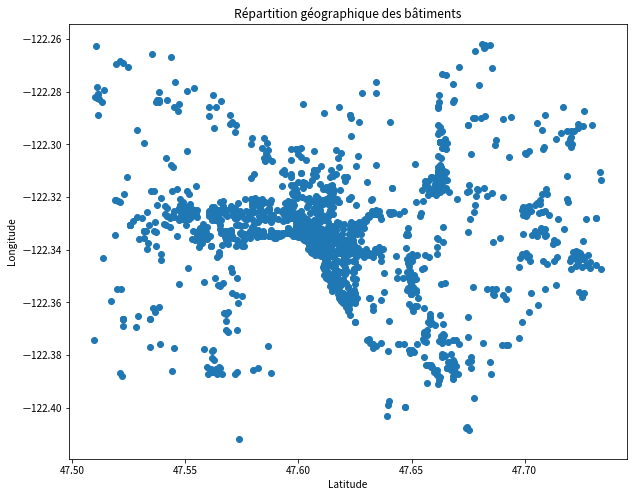

In [37]:
plt.figure(figsize = (10,8))
plt.scatter(data["Latitude"],data["Longitude"])
plt.title("Répartition géographique des bâtiments")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

# Center of Seattle
########################
# 47.608013, -122.335167
########################

Text(0.5, 0, 'Distance au centre de Seattle')

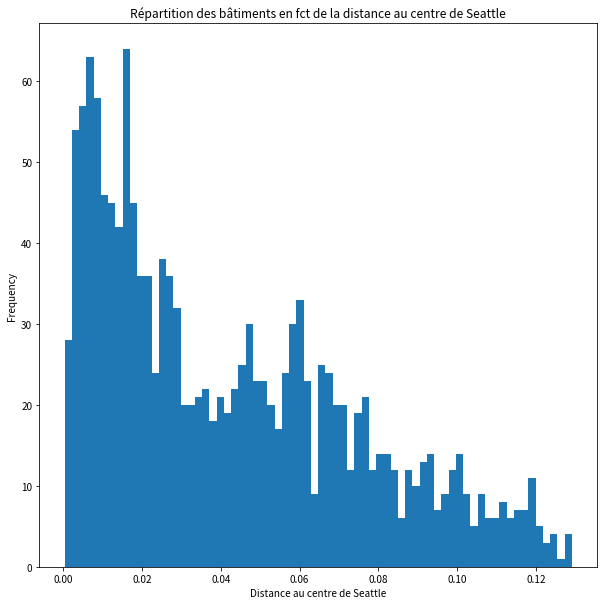

In [38]:
data["DistanceFromCenter"].plot.hist(bins = 70, figsize = (10,10))
plt.title("Répartition des bâtiments en fct de la distance au centre de Seattle")
plt.xlabel("Distance au centre de Seattle")

Text(0.5, 0, 'Surface (log)')

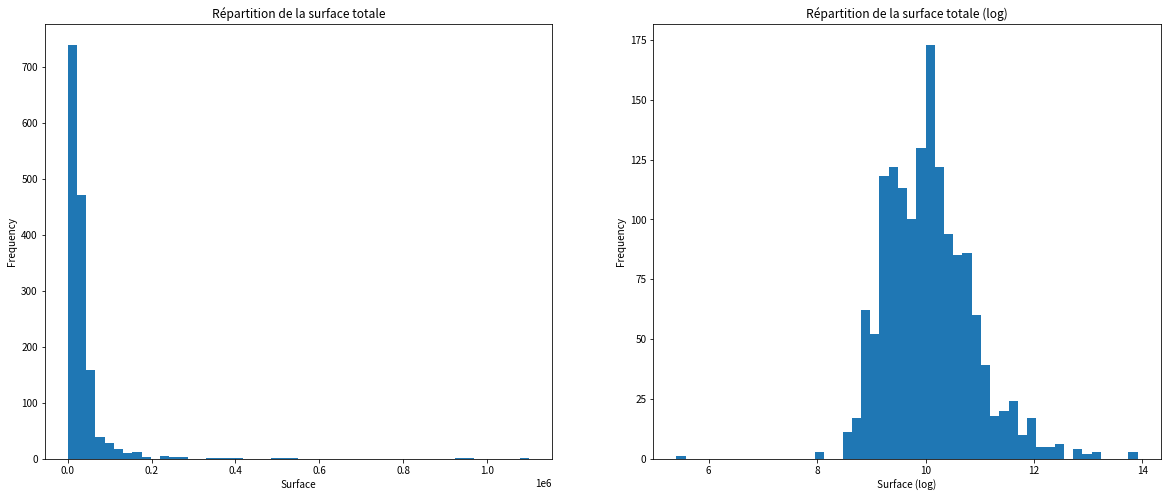

In [39]:
plt.subplot(1,2,1)
data["PropertyGFATotal"].plot.hist(figsize = (20,8), bins = 50)
plt.title("Répartition de la surface totale")
plt.xlabel("Surface")
plt.subplot(1,2,2)
np.log(1+data["PropertyGFATotal"]).plot.hist(figsize = (20,8), bins = 50)
plt.title("Répartition de la surface totale (log)")
plt.xlabel("Surface (log)")

Text(0.5, 0, '%')

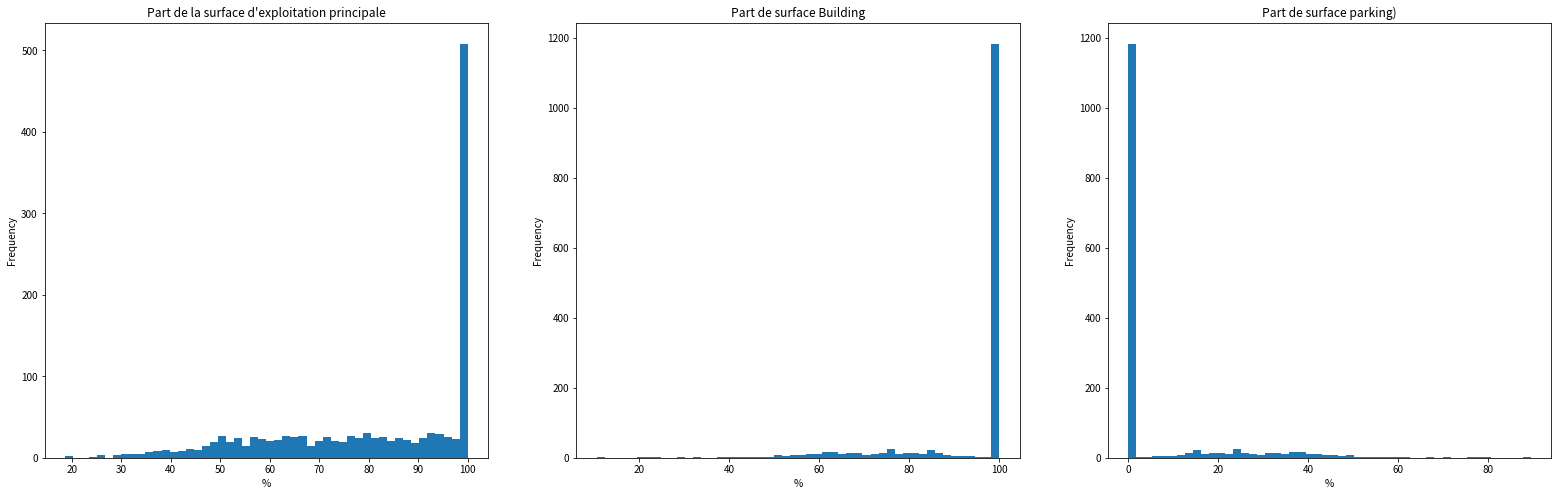

In [40]:
plt.subplot(1,3,1)
data.loc[data["LargestPropertyUseTypeGFApct"] <= 100,"LargestPropertyUseTypeGFApct"].plot.hist(figsize = (27,8), bins = 50)
plt.title("Part de la surface d'exploitation principale")
plt.xlabel("%")
plt.subplot(1,3,2)
data["PropertyGFApctBuilding(s)"].plot.hist(figsize = (27,8), bins = 50)
plt.title("Part de surface Building")
plt.xlabel("%")
plt.subplot(1,3,3)
data["PropertyGFApctParking"].plot.hist(figsize = (27,8), bins = 50)
plt.title("Part de surface parking)")
plt.xlabel("%")

Text(0.5, 0, 'Consomation énergetique (log)(kBtu)')

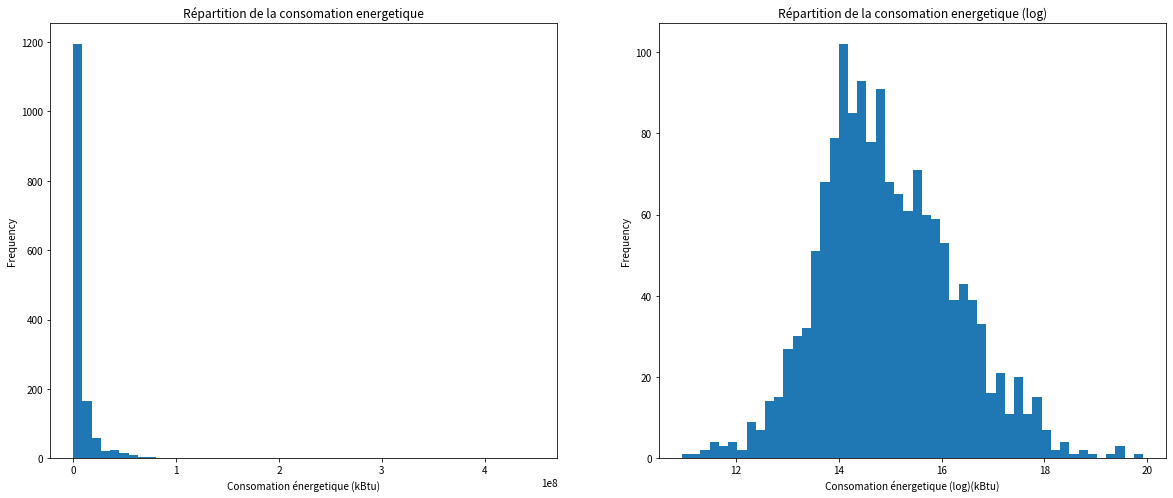

In [41]:
plt.subplot(1,2,1)
data["SiteEnergyUse(kBtu)"].plot.hist(figsize = (20,8), bins = 50)
plt.title("Répartition de la consomation energetique")
plt.xlabel("Consomation énergetique (kBtu)")
plt.subplot(1,2,2)
np.log(1+data["SiteEnergyUse(kBtu)"]).plot.hist(figsize = (20,8), bins = 50)
plt.title("Répartition de la consomation energetique (log)")
plt.xlabel("Consomation énergetique (log)(kBtu)")

Text(0.5, 0, 'Emissions (log)')

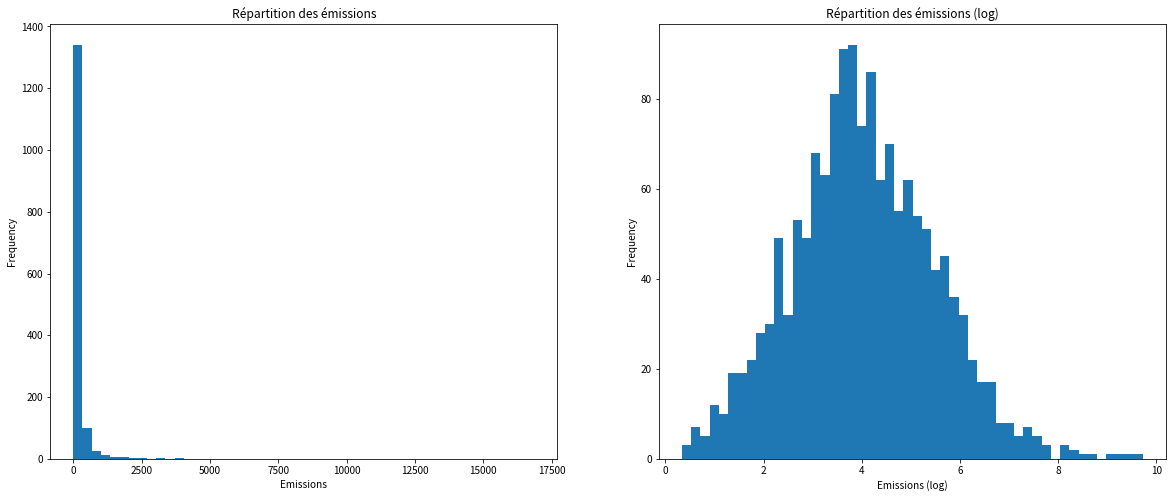

In [42]:
plt.subplot(1,2,1)
data["TotalGHGEmissions"].plot.hist(figsize = (20,8), bins = 50)
plt.title("Répartition des émissions")
plt.xlabel("Emissions")
plt.subplot(1,2,2)
np.log(1+data["TotalGHGEmissions"]).plot.hist(figsize = (20,8), bins = 50)
plt.title("Répartition des émissions (log)")
plt.xlabel("Emissions (log)")

In [43]:
data["NumberofBuildings"].value_counts().sort_index()

0.0       52
1.0     1404
2.0       13
3.0       12
4.0        4
5.0        6
6.0        4
7.0        1
8.0        2
9.0        1
10.0       1
11.0       1
14.0       2
23.0       1
27.0       1
Name: NumberofBuildings, dtype: int64

Text(0, 0.5, 'Nombre de sites')

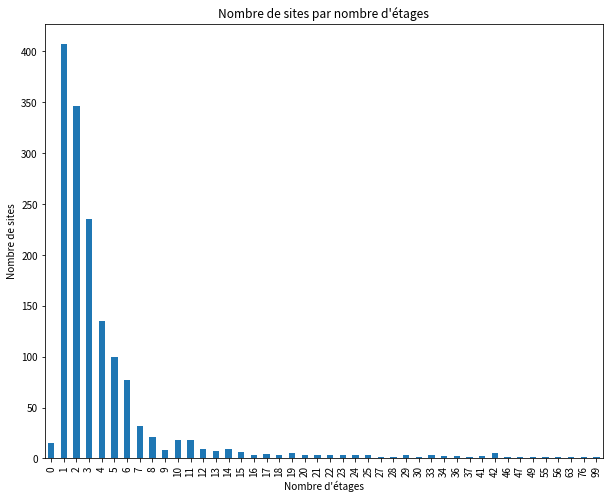

In [44]:
data["NumberofFloors"].value_counts().sort_index().plot.bar(figsize =(10,8))
plt.title("Nombre de sites par nombre d'étages")
plt.xlabel("Nombre d'étages")
plt.ylabel("Nombre de sites")

Text(0, 0.5, 'Nombre de batiments')

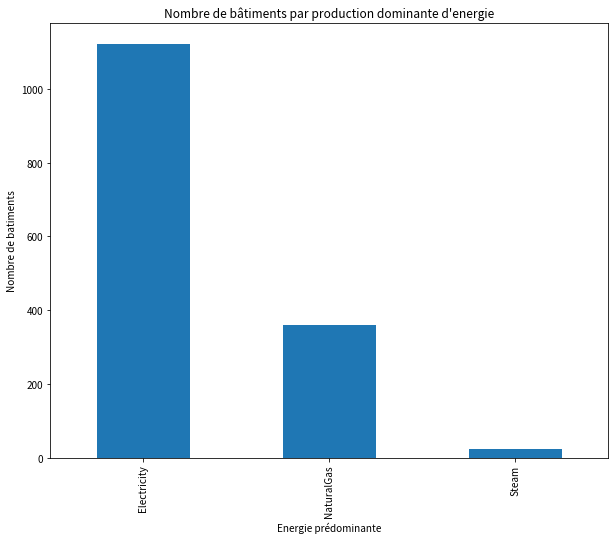

In [45]:
data["BiggestEnergyProduction"].value_counts().plot.bar(figsize =(10,8))
plt.title("Nombre de bâtiments par production dominante d'energie")
plt.xlabel("Energie prédominante")
plt.ylabel("Nombre de batiments")

Text(0.5, 1.0, 'NaturalGasProdPct')

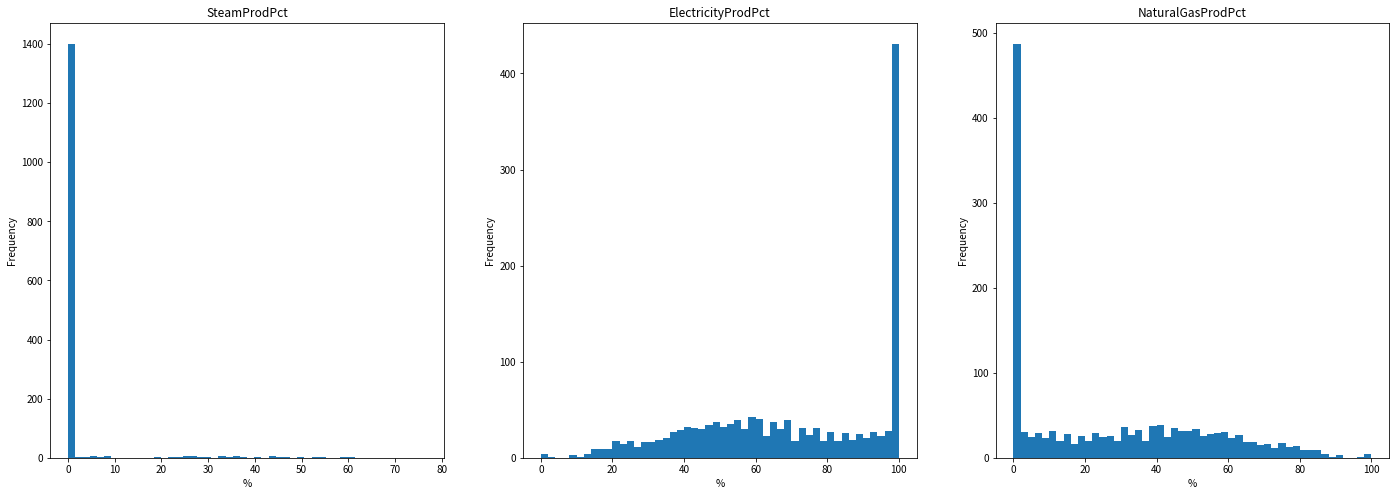

In [46]:
plt.subplot(1,3,1)
data["SteamProdPct"].plot.hist(bins = 50, figsize = (24,8))
plt.xlabel("%")
plt.title("SteamProdPct")
plt.subplot(1,3,2)
data["ElectricityProdPct"].plot.hist(bins = 50, figsize = (24,8))
plt.xlabel("%")
plt.title("ElectricityProdPct")
plt.subplot(1,3,3)
data["NaturalGasProdPct"].plot.hist(bins = 50, figsize = (24,8))
plt.xlabel("%")
plt.title("NaturalGasProdPct")

<AxesSubplot:ylabel='Frequency'>

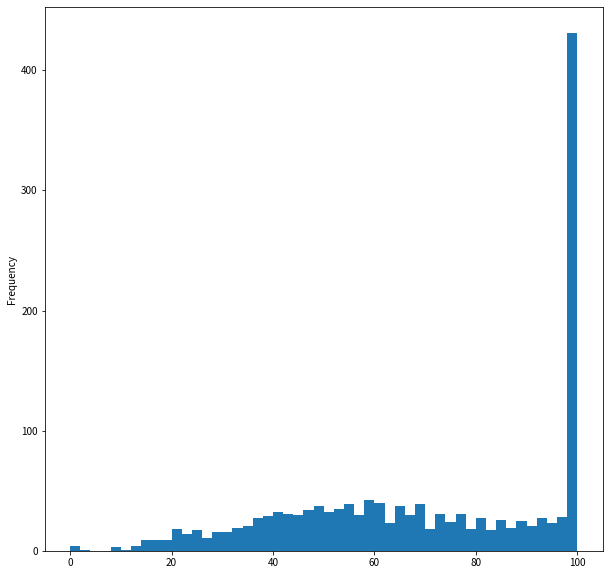

In [47]:
data["ElectricityProdPct"].plot.hist(bins = 50, figsize = (10,10))

<AxesSubplot:ylabel='Frequency'>

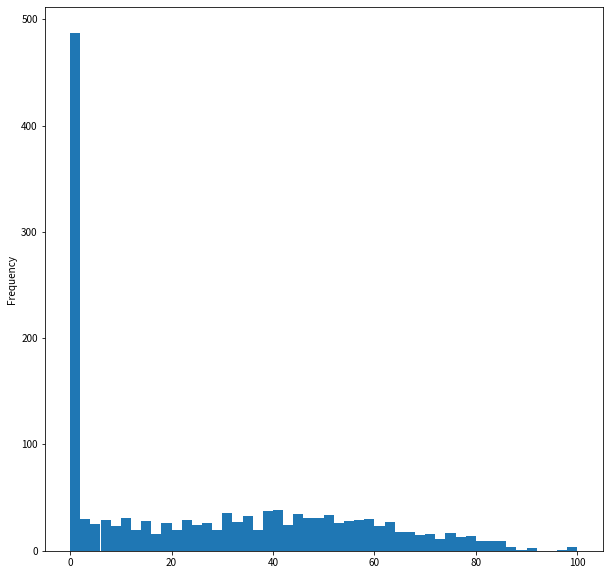

In [48]:
data["NaturalGasProdPct"].plot.hist(bins = 50, figsize = (10,10))

## <font color='green'>III/2 - Analyse bivariée </font>

Text(0.5, 1.0, 'Consomation energétique en fonction de la surface')

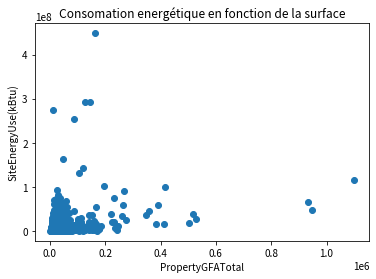

In [49]:
plt.scatter(data["PropertyGFATotal"],data["SiteEnergyUse(kBtu)"])
plt.xlabel("PropertyGFATotal")
plt.ylabel("SiteEnergyUse(kBtu)")
plt.title("Consomation energétique en fonction de la surface")

In [50]:
data = data.loc[~(data["SiteEnergyUse(kBtu)"]>2e8),:]

In [51]:
data.shape

(1500, 51)

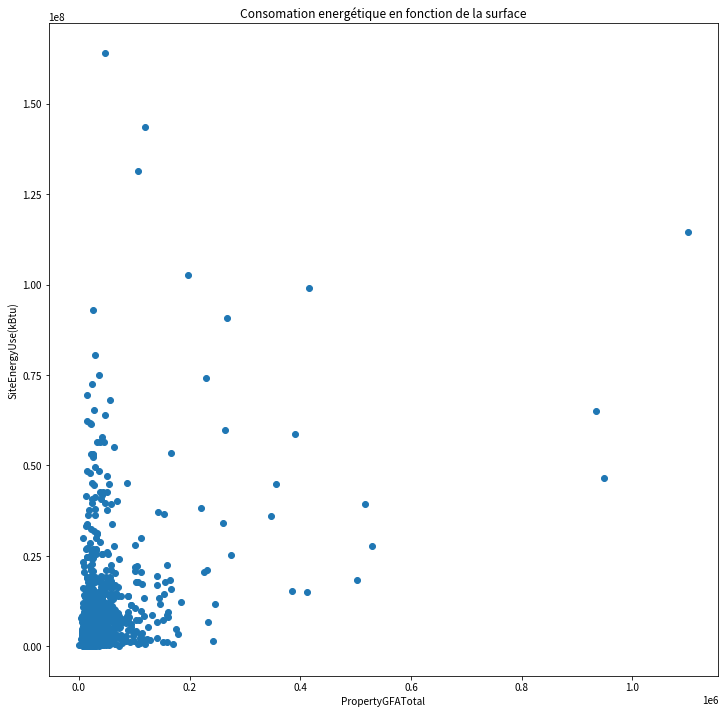

In [52]:
data.loc[:,["PropertyGFATotal","SiteEnergyUse(kBtu)"]]
plt.figure(figsize = (12,12))
plt.scatter(data["PropertyGFATotal"],data["SiteEnergyUse(kBtu)"])
plt.xlabel("PropertyGFATotal")
plt.ylabel("SiteEnergyUse(kBtu)")
plt.title("Consomation energétique en fonction de la surface")
plt.show()

Text(0, 0.5, 'Consomation energetique (kBtu)')

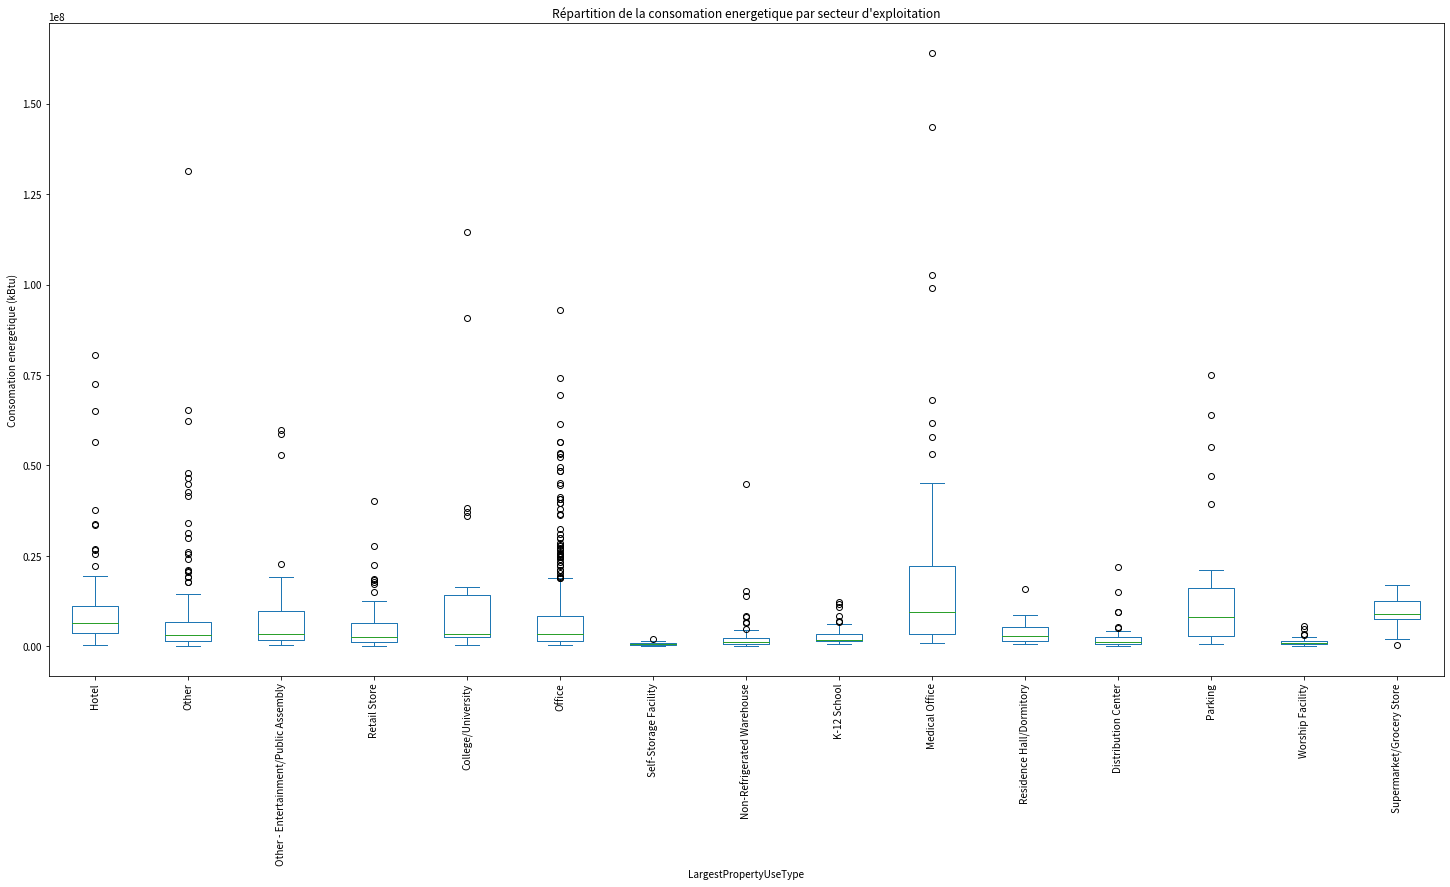

In [53]:
df = pd.DataFrame(data = np.nan, index = [i for i in range(1513)], columns = data["LargestPropertyUseType"].unique())
for e in df.columns :
    newCol = data.loc[data["LargestPropertyUseType"] == e,"SiteEnergyUse(kBtu)"]
    newCol.reset_index(drop = True, inplace =True)
    df.loc[:,e] = newCol.copy()

df.dropna(how = 'all', inplace = True)
df.plot.box(figsize=(25,12))
plt.title("Répartition de la consomation energetique par secteur d'exploitation")
plt.xlabel('LargestPropertyUseType')
plt.xticks(rotation=90)
plt.ylabel('Consomation energetique (kBtu)')

Text(0, 0.5, 'Consomation energetique (kBtu)')

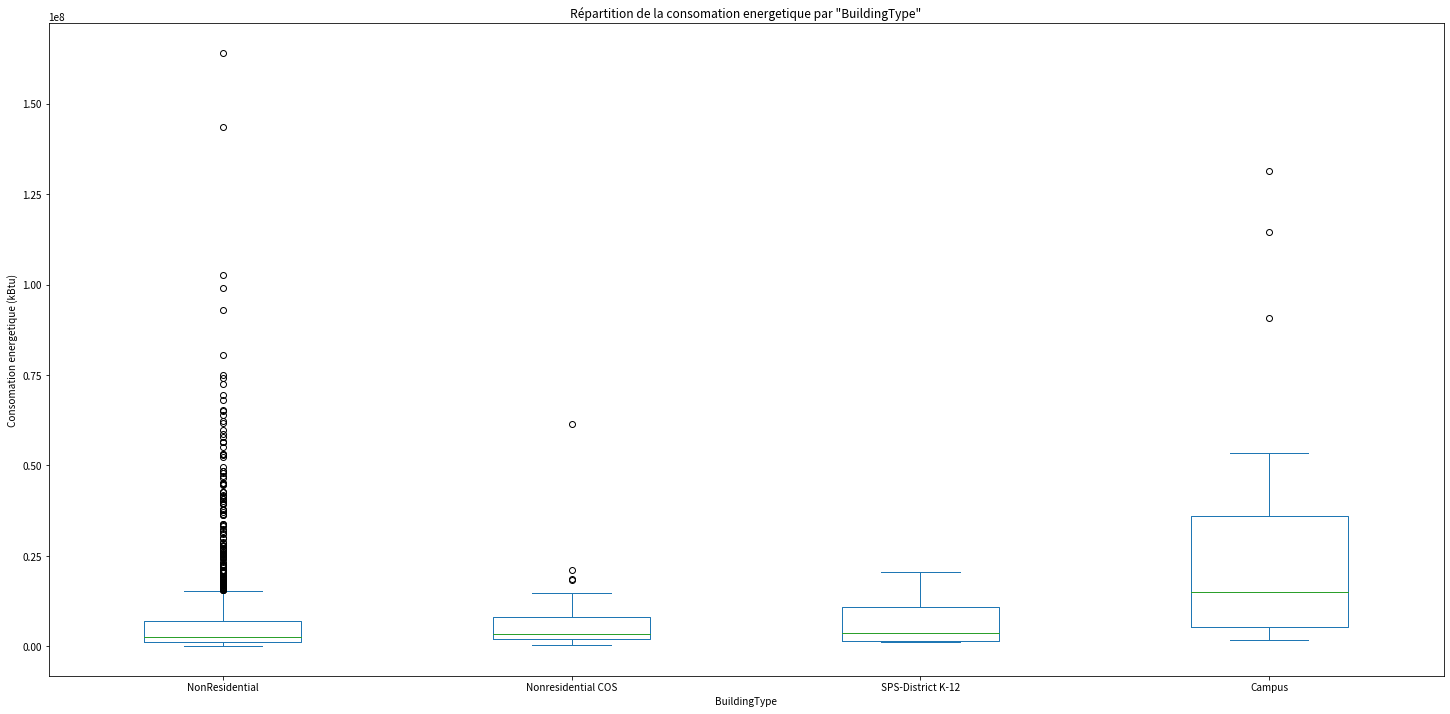

In [54]:
df = pd.DataFrame(data = np.nan, index = [i for i in range(1513)], columns = data["BuildingType"].unique())
for e in df.columns :
    newCol = data.loc[data["BuildingType"] == e,"SiteEnergyUse(kBtu)"]
    newCol.reset_index(drop = True, inplace =True)
    df.loc[:,e] = newCol.copy()

df.dropna(how = 'all', inplace = True)
df.plot.box(figsize=(25,12))
plt.title('Répartition de la consomation energetique par "BuildingType"')
plt.xlabel('BuildingType')
plt.ylabel('Consomation energetique (kBtu)')

Text(0, 0.5, 'Consomation energetique (kBtu)')

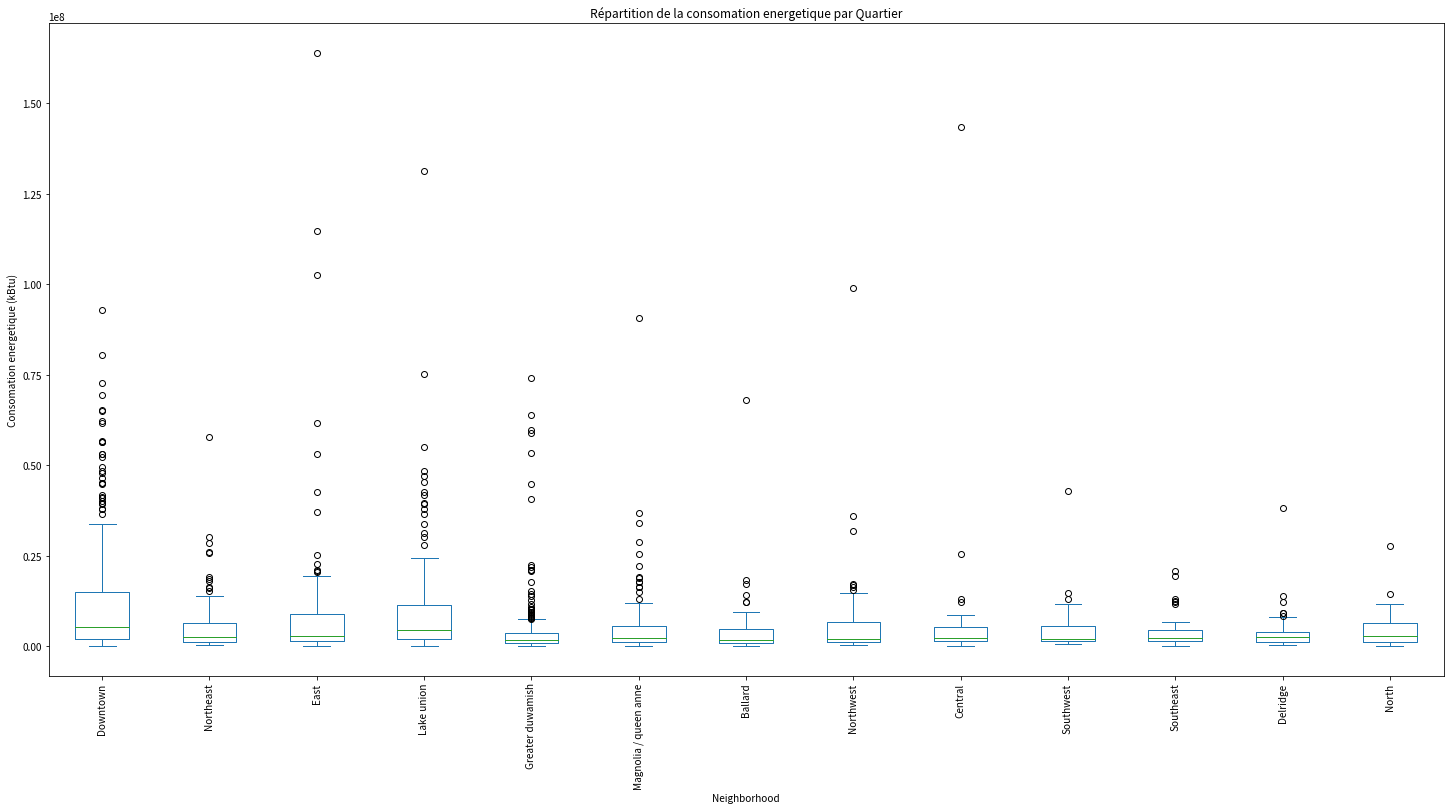

In [55]:
df = pd.DataFrame(data = np.nan, index = [i for i in range(1513)], columns = data["Neighborhood"].unique())
for e in df.columns :
    newCol = data.loc[data["Neighborhood"] == e,"SiteEnergyUse(kBtu)"]
    newCol.reset_index(drop = True, inplace =True)
    df.loc[:,e] = newCol.copy()

df.dropna(how = 'all', inplace = True)
df.plot.box(figsize=(25,12))
plt.title("Répartition de la consomation energetique par Quartier")
plt.xlabel("Neighborhood")
plt.xticks(rotation=90)
plt.ylabel('Consomation energetique (kBtu)')

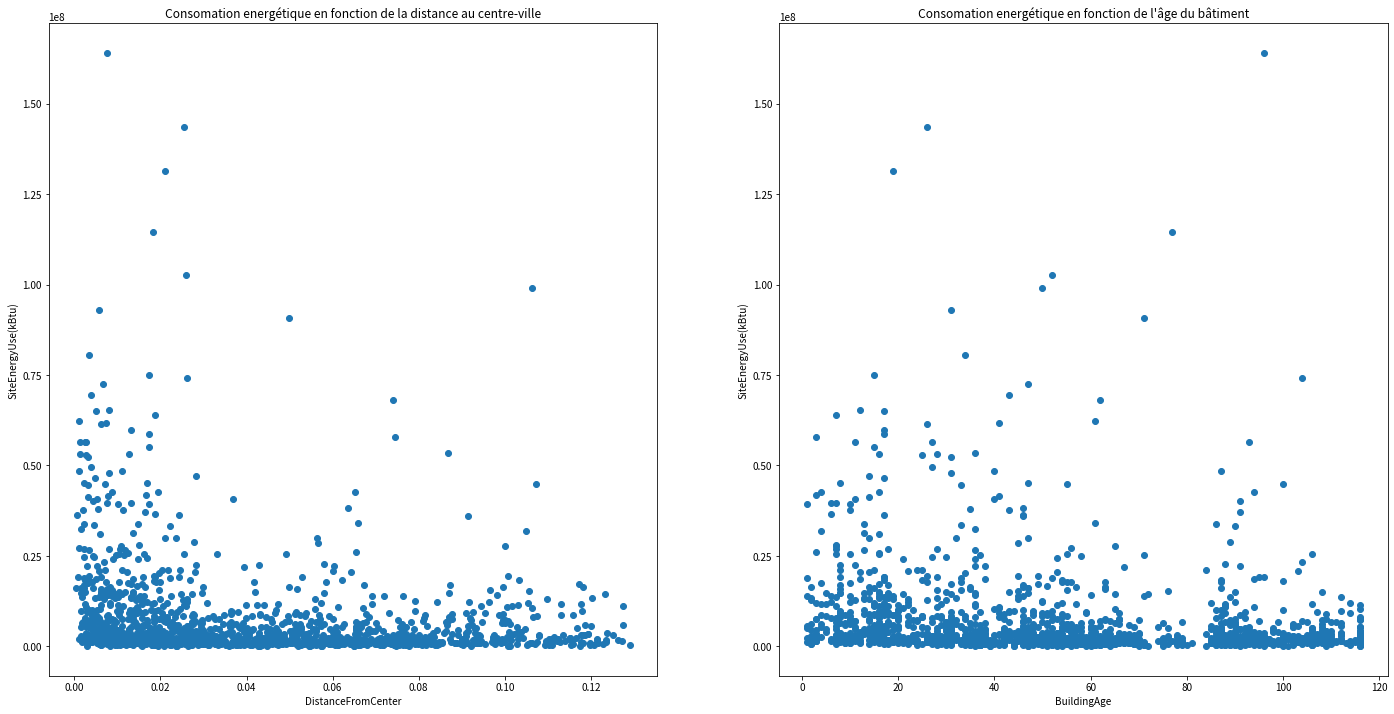

In [56]:
plt.figure(figsize = (24,12))
plt.subplot(1,2,1)
plt.scatter(data["DistanceFromCenter"],data["SiteEnergyUse(kBtu)"])
plt.xlabel("DistanceFromCenter")
plt.ylabel("SiteEnergyUse(kBtu)")
plt.title("Consomation energétique en fonction de la distance au centre-ville")
plt.subplot(1,2,2)
plt.scatter(data["BuildingAge"],data["SiteEnergyUse(kBtu)"])
plt.xlabel("BuildingAge")
plt.ylabel("SiteEnergyUse(kBtu)")
plt.title("Consomation energétique en fonction de l'âge du bâtiment")
plt.show()

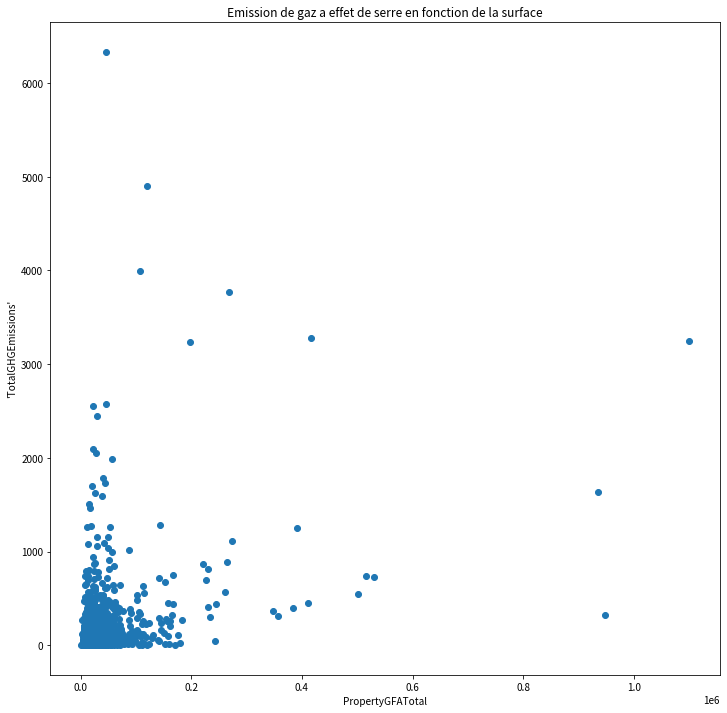

In [57]:
plt.figure(figsize = (12,12))
plt.scatter(data["PropertyGFATotal"],data['TotalGHGEmissions'])
plt.xlabel("PropertyGFATotal")
plt.ylabel("'TotalGHGEmissions'")
plt.title("Emission de gaz a effet de serre en fonction de la surface")
plt.show()

In [58]:
data.columns

Index(['OSEBuildingID', 'BuildingType', 'PrimaryPropertyType', 'PropertyName',
       'Address', 'ZipCode', 'TaxParcelIdentificationNumber',
       'CouncilDistrictCode', 'Neighborhood', 'Latitude', 'Longitude',
       'DistanceFromCenter', 'YearBuilt', 'BuildingAge', 'BuildingPeriod',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAPerFloor', 'PropertyGFAParking', 'PropertyGFApctParking',
       'PropertyGFABuilding(s)', 'PropertyGFApctBuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'LargestPropertyUseTypeGFApct',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'NumberOfUseTypes', 'YearsENERGYSTARCertified', 'ENERGYSTARScore',
       'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)',
       'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)',
       '

Text(0, 0.5, 'Emission de GES (kBtu)')

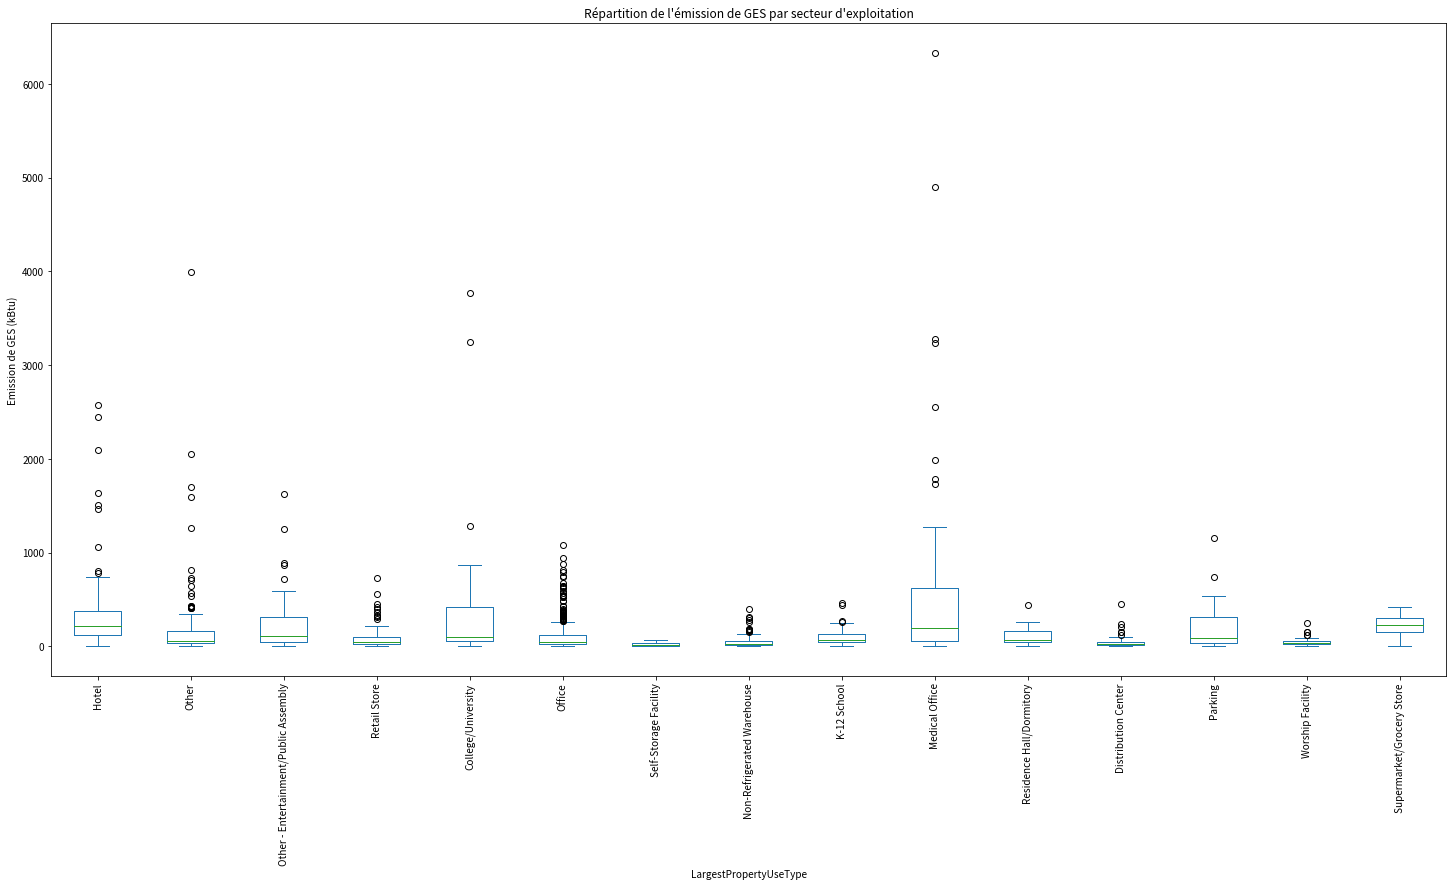

In [59]:
df = pd.DataFrame(data = np.nan, index = [i for i in range(1513)], columns = data["LargestPropertyUseType"].unique())
for e in df.columns :
    newCol = data.loc[data["LargestPropertyUseType"] == e,'TotalGHGEmissions']
    newCol.reset_index(drop = True, inplace =True)
    df.loc[:,e] = newCol.copy()

df.dropna(how = 'all', inplace = True)
df.plot.box(figsize=(25,12))
plt.title("Répartition de l'émission de GES par secteur d'exploitation")
plt.xlabel('LargestPropertyUseType')
plt.xticks(rotation=90)
plt.ylabel('Emission de GES (kBtu)')

Text(0, 0.5, 'Emission de GES (kBtu)')

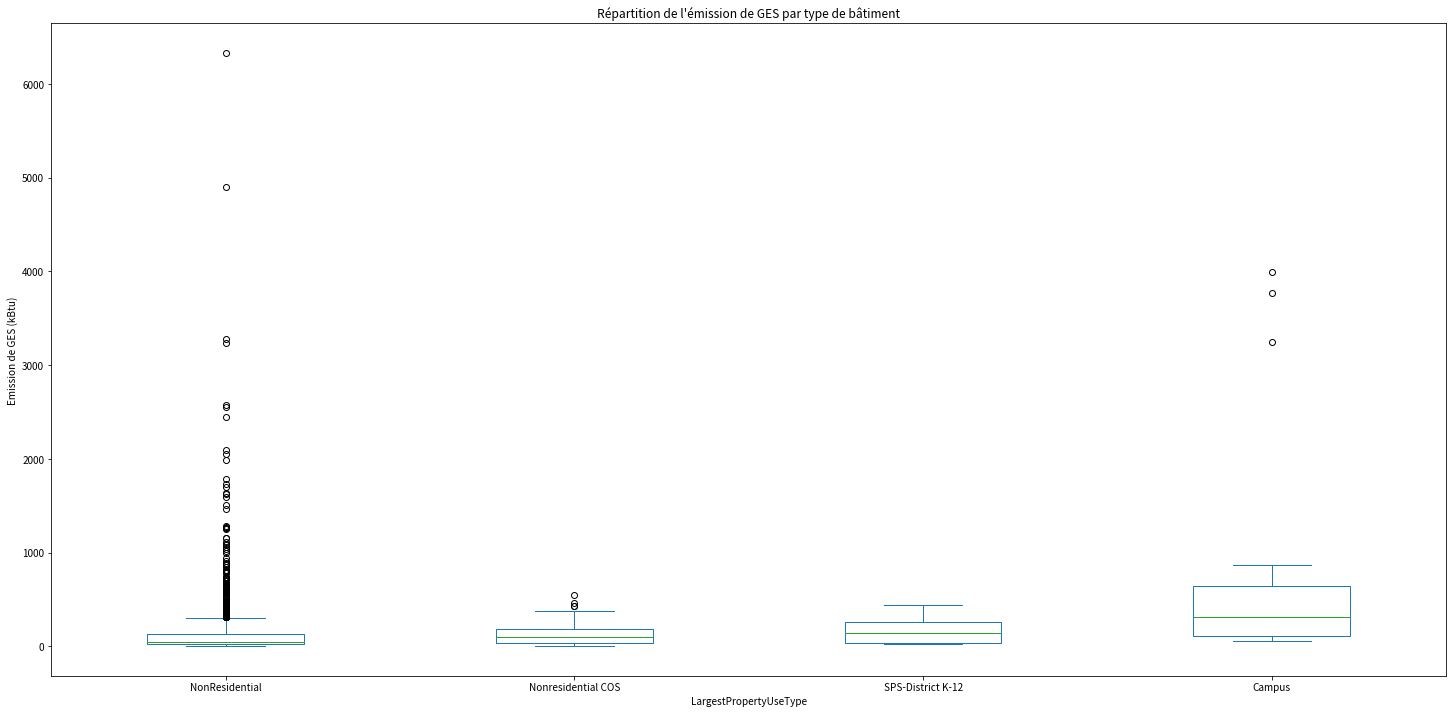

In [60]:
df = pd.DataFrame(data = np.nan, index = [i for i in range(1513)], columns = data["BuildingType"].unique())
for e in df.columns :
    newCol = data.loc[data["BuildingType"] == e,'TotalGHGEmissions']
    newCol.reset_index(drop = True, inplace =True)
    df.loc[:,e] = newCol.copy()

df.dropna(how = 'all', inplace = True)
df.plot.box(figsize=(25,12))
plt.title("Répartition de l'émission de GES par type de bâtiment")
plt.xlabel('LargestPropertyUseType')
plt.ylabel('Emission de GES (kBtu)')

Text(0, 0.5, 'Emission de GES (kBtu)')

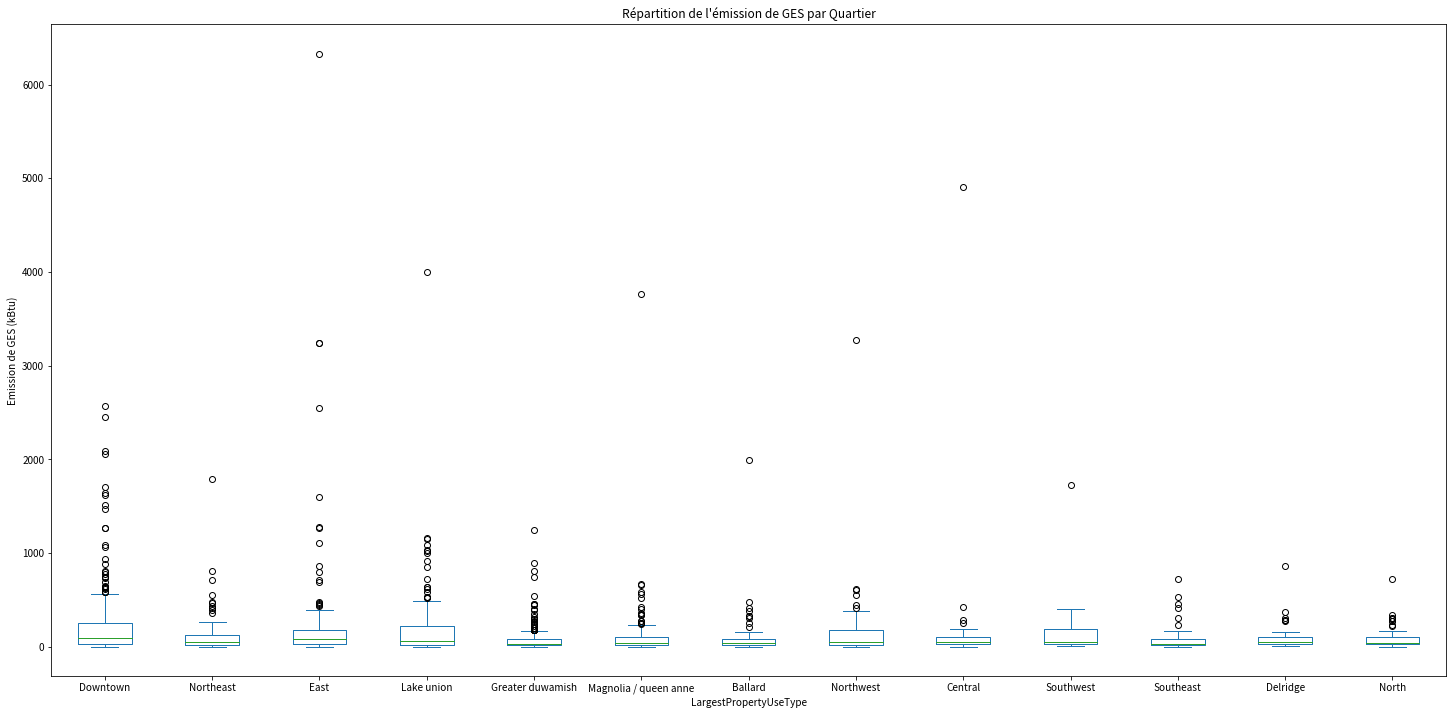

In [61]:
df = pd.DataFrame(data = np.nan, index = [i for i in range(1513)], columns = data["Neighborhood"].unique())
for e in df.columns :
    newCol = data.loc[data["Neighborhood"] == e,'TotalGHGEmissions']
    newCol.reset_index(drop = True, inplace =True)
    df.loc[:,e] = newCol.copy()

df.dropna(how = 'all', inplace = True)
df.plot.box(figsize=(25,12))
plt.title("Répartition de l'émission de GES par Quartier")
plt.xlabel('LargestPropertyUseType')
plt.ylabel('Emission de GES (kBtu)')

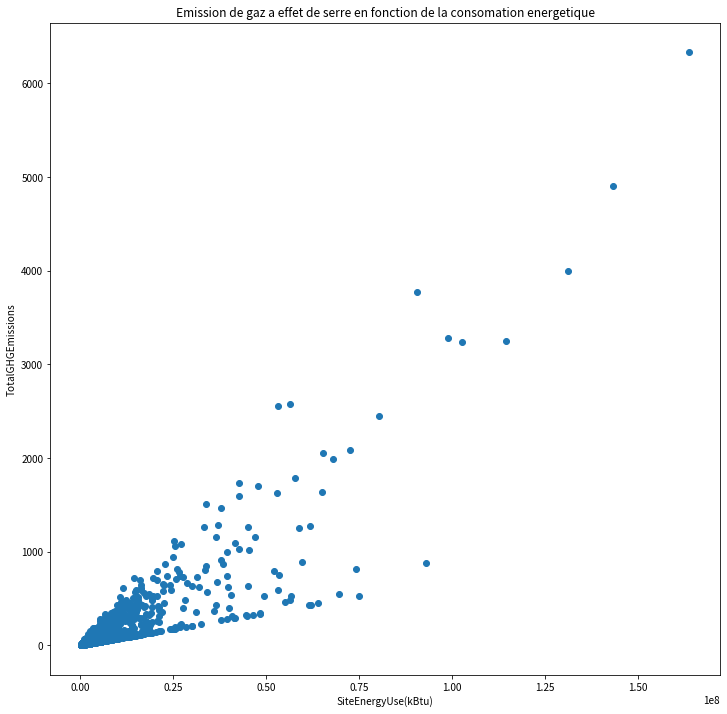

In [62]:
plt.figure(figsize = (12,12))
plt.scatter(data["SiteEnergyUse(kBtu)"],data['TotalGHGEmissions'])
plt.xlabel("SiteEnergyUse(kBtu)")
plt.ylabel('TotalGHGEmissions')
plt.title("Emission de gaz a effet de serre en fonction de la consomation energetique")
plt.show()

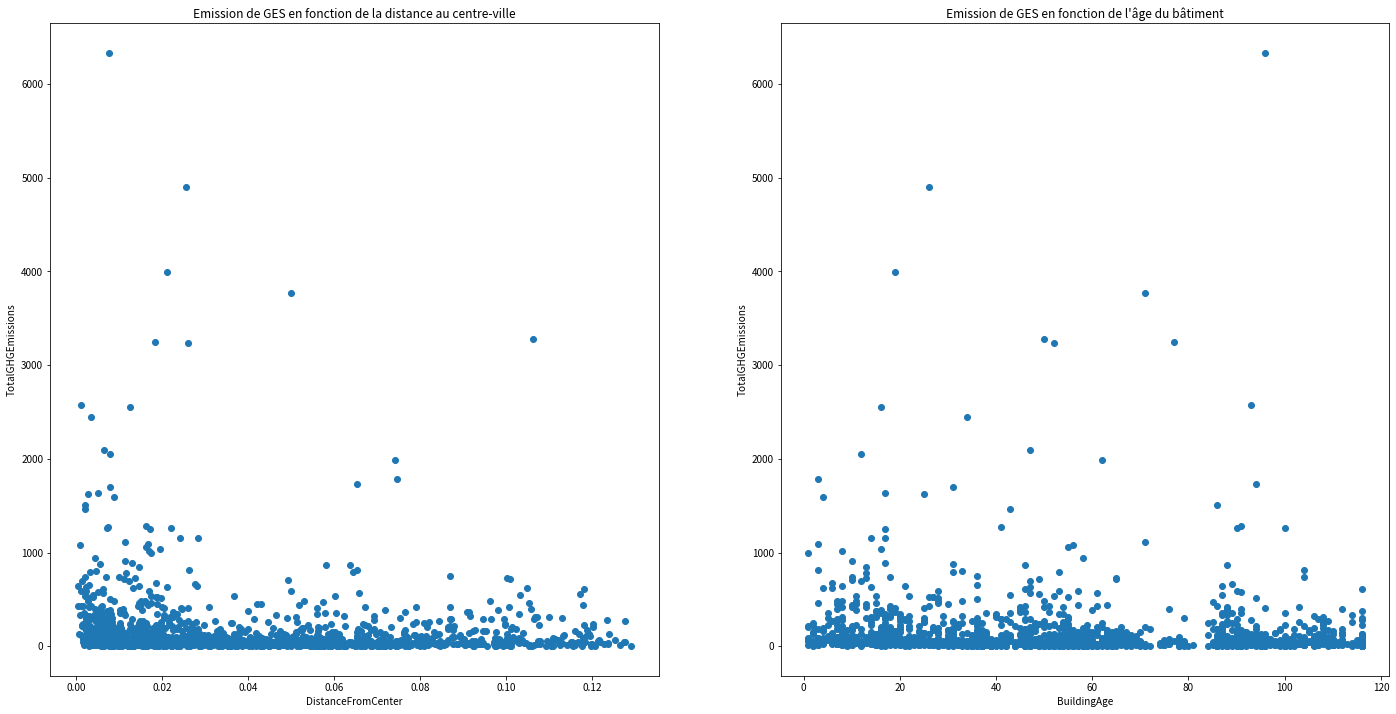

In [63]:
plt.figure(figsize = (24,12))
plt.subplot(1,2,1)
plt.scatter(data["DistanceFromCenter"],data['TotalGHGEmissions'])
plt.xlabel("DistanceFromCenter")
plt.ylabel('TotalGHGEmissions')
plt.title("Emission de GES en fonction de la distance au centre-ville")
plt.subplot(1,2,2)
plt.scatter(data["BuildingAge"],data['TotalGHGEmissions'])
plt.xlabel("BuildingAge")
plt.ylabel('TotalGHGEmissions')
plt.title("Emission de GES en fonction de l'âge du bâtiment")
plt.show()

# SAUVEGARDE to_csv

In [64]:
data.reset_index(drop = True, inplace = True)
data.to_csv('modelData.csv', sep=';', index = False)